## Different imports and setup

In [1]:
# Standard import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
# Machine learning libraries
from tensorflow import keras
import tensorflow as tf

In [3]:
from Tools import Plot
from Tools import Custom_models
from Tools import Helpers

## Set the seeds and extract the testing set

In [4]:
# Set the seed for reproducibility
seed = 6
np.random.seed(seed)
tf.random.set_seed(seed*2)

In [5]:
_, _, _, _, features_test, labels_test = Helpers.Load_and_split_val(
    'Data/tanh_1D.txt', D=1, seed=seed, ratio_test=0.1, ratio_val=0.1)

In [7]:
model_name = f'Saved_models/1D/1_layer_width_study/batch_32-K_20-iter_0'
model = keras.models.load_model(model_name)
model.summary()

Model: "batch_32-K_20-lr_3.0e-04"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1)                 61        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


## Load a model

In [8]:
MSE = []
MAE = []
MaAE = []

for i in range(5):
    model_name = f'Saved_models/1D/1_layer_width_study/batch_32-K_20-iter_{i}'
    model = keras.models.load_model(model_name)
    MSE.append(Helpers.MSE(model, features_test, labels_test))
    MAE.append(Helpers.MAE(model, features_test, labels_test))
    MaAE.append(Helpers.MaAE(model, features_test, labels_test))

2021-12-28 20:18:11.122922: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-28 20:18:11.123095: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [9]:
# Check the min, mean, and max
a = MSE
print(f'Min : {np.min(a):.4e}')
print(f'Mean : {np.mean(a):.4e}')
print(f'Max : {np.max(a):.4e}')

Min : 9.1656e-06
Mean : 1.0433e-05
Max : 1.3279e-05


In [10]:
best = np.argmin(MSE)
best

3

In [11]:
model_name = f'Saved_models/1D/1_layer_width_study/batch_32-K_20-iter_{best}'
model = keras.models.load_model(model_name)
history = pd.read_csv(model_name + '.csv')

In [12]:
model.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0003>

## Assess the performance of the model on the testing set

In [13]:
mse = Helpers.MSE(model, features_test, labels_test)
mae = Helpers.MAE(model, features_test, labels_test)
maae = Helpers.MaAE(model, features_test, labels_test)
print(f'The MSE is : {mse:.4e}')
print(f'The MAE is : {mae:.4e}')
print(f'The MaAE is : {maae:.4e}')

The MSE is : 9.1656e-06
The MAE is : 1.2833e-03
The MaAE is : 1.9392e-02


## Print the history

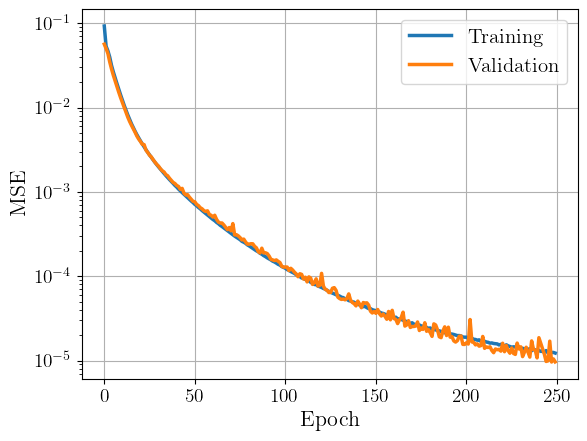

In [14]:
save = False
name = 'Figures/1D/Conv_non_trainable/best_training_error.pdf'

plt.figure()
plt.plot(history['epoch'], history['loss'])
plt.plot(history['epoch'], history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Training', 'Validation'])
plt.yscale('log')
plt.grid()
if (save):
    plt.savefig(name, bbox_inches='tight')
plt.show()

## Plot the approximation

In [15]:
sorting = np.argsort(features_test.ravel())
features_testing = features_test[sorting]
labels_testing = labels_test[sorting]

prediction = model.predict(features_testing)
prediction = np.ravel(prediction)

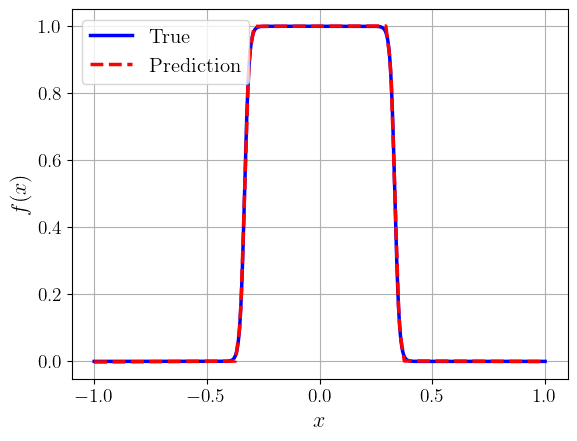

In [17]:
save = False
name = 'Figures/1D/Conv_non_trainable/best_approximation_zoom.pdf'

plt.figure()
plt.plot(features_testing, labels_testing, 'b-', label='True')
plt.plot(features_testing, prediction, 'r--', label='Prediction')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend()
plt.grid()
#plt.xlim([-0.38, -0.3])
if (save):
    plt.savefig(name, bbox_inches='tight')
plt.show()

## Print a summary of the loaded model

In [20]:
model.summary()

Model: "Conv_K_100-batch_32-lr_5.0e-05"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               multiple                  200       
_________________________________________________________________
conv (Conv1D)                multiple                  4         
_________________________________________________________________
dense2 (Dense)               multiple                  101       
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


## Extract layers of the model

In [30]:
L = 10
layers = [model.sequence.get_layer(name=f'dense{i}') for i in range(1,L+1)]

In [102]:
# If conv
layer1 = model.get_layer(name='dense1')
layer2 = model.get_layer(name='conv')

## Compute the basis functions created by the model

In [103]:
# Computes the interval on which evaluate the basis functions and the real solution
x = np.linspace(-1, 1, 100000)
y = 1/2*(1 + np.tanh(50*(x+1/3))) - 1/2*(1 + np.tanh(50*(x-1/3)))

In [104]:
# If conv
basis_func_layer1 = Helpers.basis_functions_layer(x, [layer1])
basis_func_layer2 = Helpers.basis_functions_conv_layer(x, layer1, layer2)

In [31]:
basis = [Helpers.basis_functions_layer(x, layers[0:i]) for i in range(1, L+1)]

## Visualize the basis functions

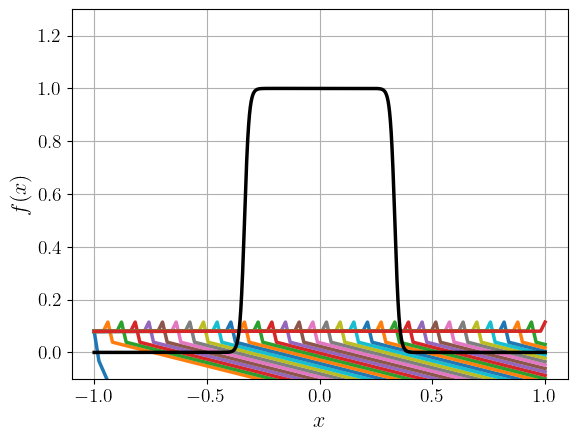

In [112]:
filename = 'Figures/1D/Conv_non_trainable/best_relu_conv_layer.pdf'
save = False

# To visualize only one function each offset values
offset = 3

# To visualize the right layer
basis_func = basis_func_layer2

plt.figure()
for i in range(0, len(basis_func), offset):
    plt.plot(x, basis_func[i,:])
plt.plot(x, y, 'k-')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim([-0.1, 1.3])
plt.grid()
if save:
    plt.savefig(filename, bbox_inches='tight')
plt.show()

In [106]:
layer2.get_weights()

[array([[[ 1.7261326]],
 
        [[-5.4948864]],
 
        [[ 3.554145 ]]], dtype=float32),
 array([0.08002721], dtype=float32)]

## Inspect raw weights

In [ ]:
print(bias2)

In [ ]:
print(core2)

In [ ]:
-bias1/core1 < 1

In [292]:
plt.close('all')